# Sistem Rekomendasi Anime - Proyek Akhir Machine Learning Terapan

**Nama:** Rakha Alif Athallah
**ID Dicoding:** MC006D5Y1328

## Deskripsi Proyek
Proyek ini membangun sistem rekomendasi anime menggunakan dua pendekatan:
1. **Content-Based Filtering** - Berdasarkan kesamaan konten anime (genre, tipe)
2. **Collaborative Filtering** - Berdasarkan preferensi pengguna serupa

Dataset yang digunakan berisi informasi anime dan rating pengguna dari platform anime populer.

**Tujuan:** Membangun sistem yang dapat memberikan rekomendasi anime yang akurat dan relevan.

## 1. Import Library dan Setup

- Manipulasi data (pandas, numpy)
- Machine learning (scikit-learn)
- Visualisasi (matplotlib, seaborn)
- Text processing (TF-IDF, cosine similarity)

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Setting untuk visualisasi
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Definisi Class Sistem Rekomendasi

**Tujuan:** Membuat class yang berisi semua fungsi untuk membangun sistem rekomendasi anime:
- Data loading dan preprocessing
- Content-based filtering dengan TF-IDF dan Cosine Similarity
- Collaborative filtering dengan SVD matrix factorization
- Evaluasi model dengan metrik yang sesuai

**Pendekatan:** Object-oriented programming untuk modularitas dan reusability.

In [ ]:
class AnimeRecommendationSystem:
    def __init__(self, anime_path, rating_path):
        """
        Inisialisasi sistem rekomendasi anime
        
        Parameters:
        anime_path (str): Path ke file anime.csv
        rating_path (str): Path ke file rating.csv
        """
        try:
            print("🔄 Memuat dataset...")
            self.anime_df = pd.read_csv(anime_path)
            self.rating_df = pd.read_csv(rating_path)
            self.content_similarity_matrix = None
            self.collaborative_model = None
            self.user_factors = None
            self.item_factors = None
            self.merged_df = None
            self.user_item_matrix = None
            print(f"✅ Data berhasil dimuat: {len(self.anime_df):,} anime, {len(self.rating_df):,} ratings")
        except FileNotFoundError as e:
            print(f"❌ File tidak ditemukan: {e}")
            raise
        except Exception as e:
            print(f"❌ Error saat memuat data: {e}")
            raise
        
    def data_understanding(self):
        """Analisis mendalam struktur dan kualitas data"""
        print("\n=== 📊 DATA UNDERSTANDING ===\n")
        
        # Informasi dasar dataset
        print("📋 INFORMASI DATASET:")
        print(f"   • Anime dataset: {self.anime_df.shape[0]:,} baris, {self.anime_df.shape[1]} kolom")
        print(f"   • Rating dataset: {self.rating_df.shape[0]:,} baris, {self.rating_df.shape[1]} kolom")
        
        # Kolom yang tersedia
        print(f"\n📂 KOLOM ANIME DATASET:")
        for i, col in enumerate(self.anime_df.columns, 1):
            print(f"   {i}. {col}")
        
        print(f"\n📂 KOLOM RATING DATASET:")
        for i, col in enumerate(self.rating_df.columns, 1):
            print(f"   {i}. {col}")
        
        # Analisis missing values
        print(f"\n🔍 MISSING VALUES ANALYSIS:")
        print("\n📺 Anime Dataset:")
        anime_missing = self.anime_df.isnull().sum()
        total_anime = len(self.anime_df)
        for col, missing in anime_missing.items():
            percentage = (missing/total_anime)*100
            print(f"   • {col}: {missing:,} missing ({percentage:.1f}%)")
        
        print("\n⭐ Rating Dataset:")
        rating_missing = self.rating_df.isnull().sum()
        total_rating = len(self.rating_df)
        for col, missing in rating_missing.items():
            percentage = (missing/total_rating)*100
            print(f"   • {col}: {missing:,} missing ({percentage:.1f}%)")
        
        # Analisis duplikasi
        print(f"\n🔄 DUPLICATE ANALYSIS:")
        anime_duplicates = self.anime_df.duplicated().sum()
        rating_duplicates = self.rating_df.duplicated().sum()
        print(f"   • Anime duplicates: {anime_duplicates:,}")
        print(f"   • Rating duplicates: {rating_duplicates:,}")
        
        # Analisis outlier
        print(f"\n📈 OUTLIER ANALYSIS:")
        print(f"   • Rating range: {self.rating_df['rating'].min()} - {self.rating_df['rating'].max()}")
        
        # Rating -1 (special case)
        invalid_ratings = self.rating_df[self.rating_df['rating'] == -1]
        print(f"   • Ratings with -1 (watched but not rated): {len(invalid_ratings):,}")
        
        # Statistik pengguna
        print(f"\n👥 USER & ANIME STATISTICS:")
        print(f"   • Total unique users: {self.rating_df['user_id'].nunique():,}")
        print(f"   • Total unique anime: {self.rating_df['anime_id'].nunique():,}")
        print(f"   • Average rating: {self.rating_df[self.rating_df['rating'] != -1]['rating'].mean():.2f}")
        
        # Sparsity calculation
        n_users = self.rating_df['user_id'].nunique()
        n_anime = self.rating_df['anime_id'].nunique()
        n_ratings = len(self.rating_df[self.rating_df['rating'] != -1])
        sparsity = 1 - (n_ratings / (n_users * n_anime))
        print(f"   • Matrix sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
        
        return self.anime_df.head(), self.rating_df.head()
    
    def data_preparation(self):
        """Preprocessing dan cleaning data untuk modeling"""
        print("\n=== 🔧 DATA PREPARATION ===\n")
        
        print("🛠️  LANGKAH PREPROCESSING:")
        
        # Handle missing values
        print("\n1️⃣ Mengisi missing values...")
        before_fill = self.anime_df.isnull().sum().sum()
        
        self.anime_df['genre'] = self.anime_df['genre'].fillna('Unknown')
        self.anime_df['type'] = self.anime_df['type'].fillna('Unknown')
        self.anime_df['rating'] = self.anime_df['rating'].fillna(0)
        self.anime_df['episodes'] = self.anime_df['episodes'].fillna(0)
        
        after_fill = self.anime_df.isnull().sum().sum()
        print(f"   ✅ Missing values: {before_fill} → {after_fill}")
        
        # Remove invalid ratings
        print("\n2️⃣ Menghapus rating tidak valid (-1)...")
        initial_count = len(self.rating_df)
        self.rating_df = self.rating_df[self.rating_df['rating'] != -1]
        removed_count = initial_count - len(self.rating_df)
        print(f"   ✅ Dihapus: {removed_count:,} ratings dengan nilai -1")
        print(f"   ✅ Tersisa: {len(self.rating_df):,} valid ratings")
        
        # Merge datasets
        print("\n3️⃣ Menggabungkan dataset...")
        self.merged_df = self.rating_df.merge(self.anime_df, on='anime_id', how='left')
        print(f"   ✅ Merged dataset: {len(self.merged_df):,} baris")
        
        # Summary
        print(f"\n📊 SUMMARY DATA PREPARATION:")
        print(f"   • Clean anime data: {len(self.anime_df):,} records")
        print(f"   • Valid ratings: {len(self.rating_df):,} records")
        print(f"   • Merged data: {len(self.merged_df):,} records")
        
        print("\n✅ Data preparation selesai!")
        return self.merged_df.head()

✅ Class AnimeRecommendationSystem berhasil didefinisikan!
📝 Fungsi yang tersedia:
   • data_understanding(): Analisis mendalam dataset
   • data_preparation(): Preprocessing dan cleaning


## 3. Data Loading dan Understanding

**Tujuan:** Memuat dataset dan melakukan analisis mendalam terhadap:
- Struktur data (jumlah baris, kolom)
- Kualitas data (missing values, duplikasi, outlier)
- Karakteristik data (distribusi rating, sparsity)

**Pentingnya tahap ini:** Data understanding membantu kita memahami tantangan yang akan dihadapi dalam modeling dan menentukan strategi preprocessing yang tepat.

In [3]:
# Initialize sistem rekomendasi
print("🎌 SISTEM REKOMENDASI ANIME")
print("=" * 50)

# Load data - ganti path sesuai lokasi dataset Anda
recommender = AnimeRecommendationSystem('dataset/anime.csv', 'dataset/rating.csv')

# Analisis mendalam data
anime_head, rating_head = recommender.data_understanding()

print("\n📺 SAMPLE ANIME DATA:")
print("=" * 40)
display(anime_head)

print("\n⭐ SAMPLE RATING DATA:")
print("=" * 40)
display(rating_head)

🎌 SISTEM REKOMENDASI ANIME
🔄 Memuat dataset...
✅ Data berhasil dimuat: 12,294 anime, 7,813,737 ratings

=== 📊 DATA UNDERSTANDING ===

📋 INFORMASI DATASET:
   • Anime dataset: 12,294 baris, 7 kolom
   • Rating dataset: 7,813,737 baris, 3 kolom

📂 KOLOM ANIME DATASET:
   1. anime_id
   2. name
   3. genre
   4. type
   5. episodes
   6. rating
   7. members

📂 KOLOM RATING DATASET:
   1. user_id
   2. anime_id
   3. rating

🔍 MISSING VALUES ANALYSIS:

📺 Anime Dataset:
   • anime_id: 0 missing (0.0%)
   • name: 0 missing (0.0%)
   • genre: 62 missing (0.5%)
   • type: 25 missing (0.2%)
   • episodes: 0 missing (0.0%)
   • rating: 230 missing (1.9%)
   • members: 0 missing (0.0%)

⭐ Rating Dataset:
   • user_id: 0 missing (0.0%)
   • anime_id: 0 missing (0.0%)
   • rating: 0 missing (0.0%)

🔄 DUPLICATE ANALYSIS:
   • Anime duplicates: 0
   • Rating duplicates: 1

📈 OUTLIER ANALYSIS:
   • Rating range: -1 - 10
   • Ratings with -1 (watched but not rated): 1,476,496

👥 USER & ANIME STATISTIC

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266



⭐ SAMPLE RATING DATA:


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


**Insight dari Sample Data:**
- Anime dataset berisi informasi lengkap tentang anime (nama, genre, type, rating, episodes)
- Rating dataset berisi interaksi user-anime dengan rating 1-10 dan -1 untuk tidak rated
- Data sudah dalam format yang sesuai untuk processing lebih lanjut
- Struktur data mendukung implementasi kedua jenis sistem rekomendasi

## 4. Data Preparation

**Tujuan:** Melakukan preprocessing dan cleaning data untuk mempersiapkan modeling:
- Menangani missing values dengan strategi yang tepat
- Menghapus rating tidak valid (-1)
- Menggabungkan dataset anime dan rating
- Memastikan kualitas data untuk modeling

**Strategi:** Pendekatan konservatif untuk mempertahankan kualitas data sambil meminimalkan data loss.

In [4]:
# Proses data preparation
print("🔧 MEMULAI DATA PREPARATION")
print("=" * 50)

# Jalankan data preparation
merged_sample = recommender.data_preparation()

print("\n📋 SAMPLE MERGED DATA:")
print("=" * 40)
display(merged_sample)

# Verifikasi hasil cleaning
print("\n🔍 VERIFIKASI HASIL CLEANING:")
print(f"   • Anime data shape: {recommender.anime_df.shape}")
print(f"   • Rating data shape: {recommender.rating_df.shape}")
print(f"   • Merged data shape: {recommender.merged_df.shape}")
print(f"   • Missing values dalam anime data: {recommender.anime_df.isnull().sum().sum()}")
print(f"   • Missing values dalam rating data: {recommender.rating_df.isnull().sum().sum()}")
print(f"   • Range rating: {recommender.rating_df['rating'].min()} - {recommender.rating_df['rating'].max()}")

🔧 MEMULAI DATA PREPARATION

=== 🔧 DATA PREPARATION ===

🛠️  LANGKAH PREPROCESSING:

1️⃣ Mengisi missing values...
   ✅ Missing values: 317 → 0

2️⃣ Menghapus rating tidak valid (-1)...
   ✅ Dihapus: 1,476,496 ratings dengan nilai -1
   ✅ Tersisa: 6,337,241 valid ratings

3️⃣ Menggabungkan dataset...
   ✅ Merged dataset: 6,337,241 baris

📊 SUMMARY DATA PREPARATION:
   • Clean anime data: 12,294 records
   • Valid ratings: 6,337,241 records
   • Merged data: 6,337,241 records

✅ Data preparation selesai!

📋 SAMPLE MERGED DATA:


,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892.0
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660.0
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100.0
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657.0
4,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315.0



🔍 VERIFIKASI HASIL CLEANING:
   • Anime data shape: (12294, 7)
   • Rating data shape: (6337241, 3)
   • Merged data shape: (6337241, 9)
   • Missing values dalam anime data: 0
   • Missing values dalam rating data: 0
   • Range rating: 1 - 10


## 5. Eksplorasi Data Visual (EDA)

**Tujuan:** Memvisualisasikan distribusi dan pola data untuk:
- Memahami karakteristik dataset secara visual
- Mengidentifikasi bias atau anomali dalam data
- Mendapatkan insight untuk strategi modeling
- Memvalidasi hasil data preparation

**Visualisasi yang dibuat:**
- Distribusi rating anime dan pengguna
- Distribusi tipe anime
- Top anime berdasarkan rating
- Analisis sparsity matrix

📊 EKSPLORASI DATA VISUAL


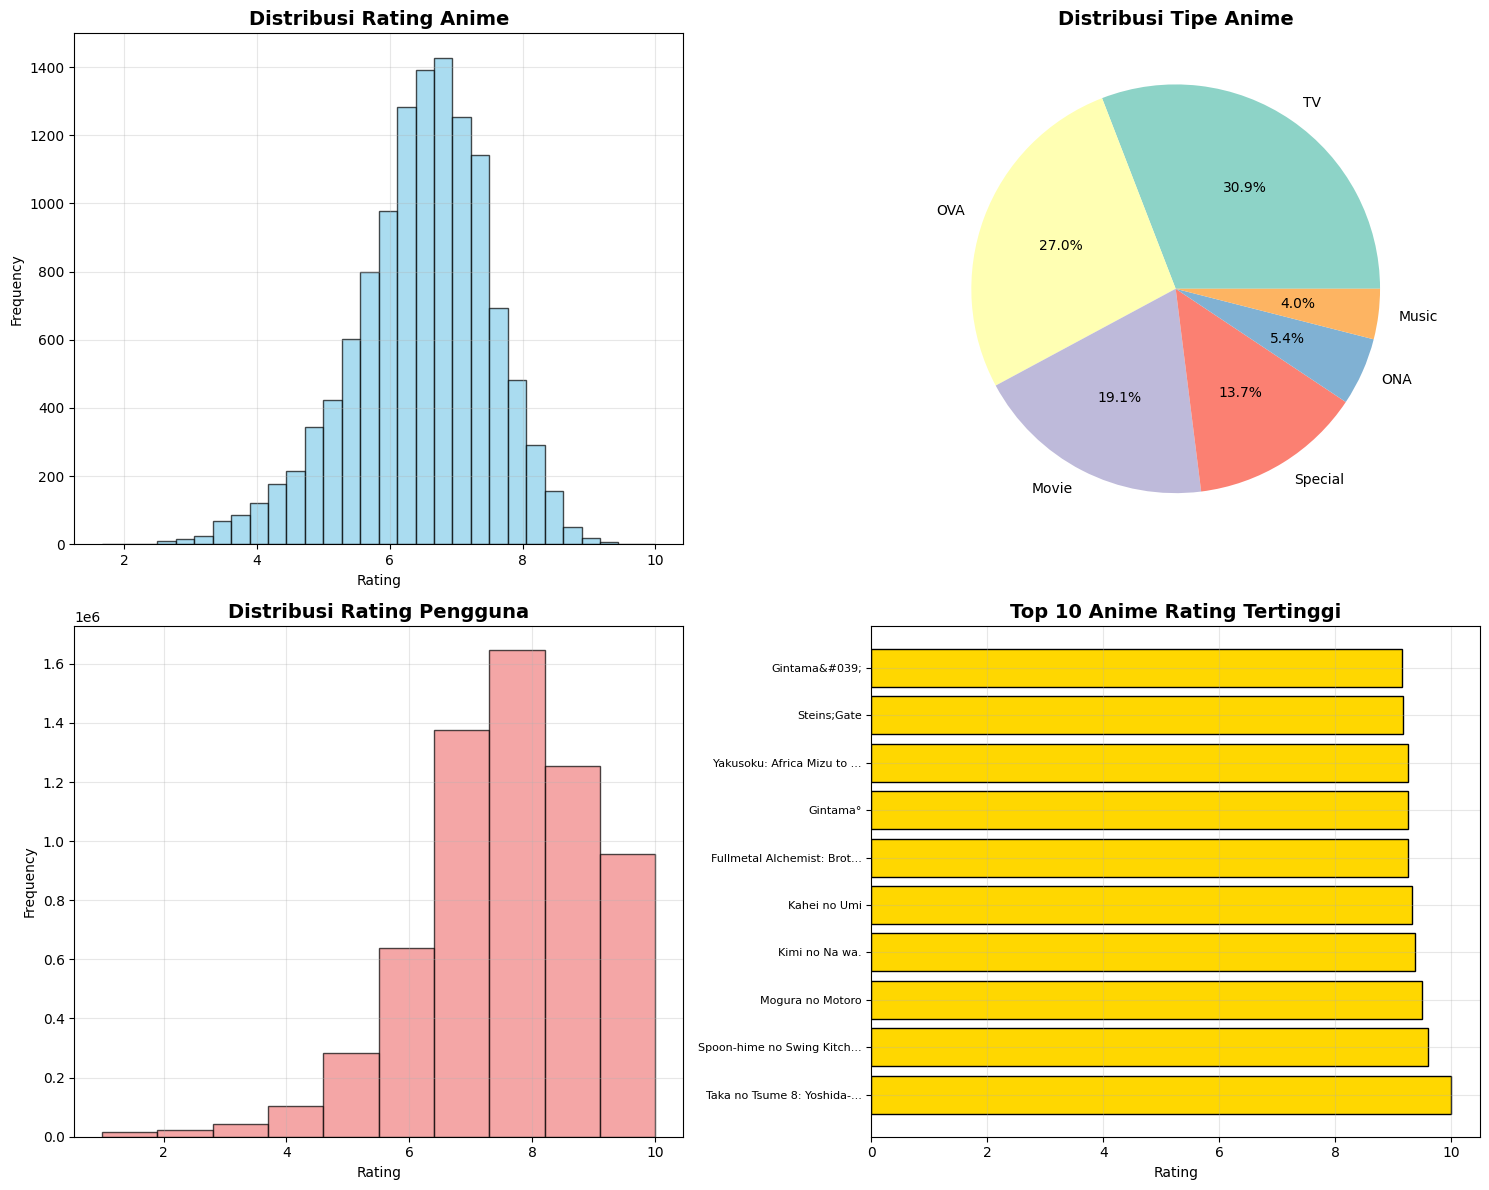


📈 STATISTIK DISTRIBUSI:
   • Rata-rata rating anime: 6.47
   • Median rating anime: 6.57
   • Rating pengguna paling sering: 8
   • Rata-rata rating pengguna: 7.81

🔍 MATRIX SPARSITY ANALYSIS:
   • Total possible interactions: 690,919,200
   • Actual interactions: 6,337,241
   • Matrix sparsity: 0.990828 (99.0828%)
   • Data density: 0.9172%


In [5]:
# Visualisasi distribusi data
print("📊 EKSPLORASI DATA VISUAL")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribusi rating anime
anime_ratings = recommender.anime_df['rating'][recommender.anime_df['rating'] > 0]
axes[0,0].hist(anime_ratings, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribusi Rating Anime', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# 2. Distribusi tipe anime
type_counts = recommender.anime_df['type'].value_counts().head(6)
colors = plt.cm.Set3(np.arange(len(type_counts)))
axes[0,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', colors=colors)
axes[0,1].set_title('Distribusi Tipe Anime', fontsize=14, fontweight='bold')

# 3. Distribusi rating pengguna
user_ratings = recommender.rating_df['rating']
axes[1,0].hist(user_ratings, bins=10, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,0].set_title('Distribusi Rating Pengguna', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(True, alpha=0.3)

# 4. Top 10 anime dengan rating tertinggi
top_anime = recommender.anime_df[recommender.anime_df['rating'] > 0].nlargest(10, 'rating')
y_pos = np.arange(len(top_anime))
axes[1,1].barh(y_pos, top_anime['rating'], color='gold', edgecolor='black')
axes[1,1].set_yticks(y_pos)
axes[1,1].set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in top_anime['name']], fontsize=8)
axes[1,1].set_title('Top 10 Anime Rating Tertinggi', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Rating')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistik tambahan
print("\n📈 STATISTIK DISTRIBUSI:")
print(f"   • Rata-rata rating anime: {anime_ratings.mean():.2f}")
print(f"   • Median rating anime: {anime_ratings.median():.2f}")
print(f"   • Rating pengguna paling sering: {user_ratings.mode()[0]}")
print(f"   • Rata-rata rating pengguna: {user_ratings.mean():.2f}")

# Analisis sparsity
n_users = recommender.rating_df['user_id'].nunique()
n_anime = recommender.rating_df['anime_id'].nunique() 
n_ratings = len(recommender.rating_df)
sparsity = 1 - (n_ratings / (n_users * n_anime))
print(f"\n🔍 MATRIX SPARSITY ANALYSIS:")
print(f"   • Total possible interactions: {n_users * n_anime:,}")
print(f"   • Actual interactions: {n_ratings:,}")
print(f"   • Matrix sparsity: {sparsity:.6f} ({sparsity*100:.4f}%)")
print(f"   • Data density: {(1-sparsity)*100:.4f}%")

## 6. Implementasi Content-Based Filtering

**Tujuan:** Membangun sistem rekomendasi berdasarkan kesamaan konten anime.

**Metodologi:**
- **TF-IDF Vectorization:** Mengubah informasi genre dan type menjadi vektor numerik
- **Cosine Similarity:** Menghitung kesamaan antar anime berdasarkan konten
- **Content Features:** Kombinasi genre dan type anime sebagai fitur utama

**Keunggulan:** Dapat memberikan rekomendasi untuk anime baru tanpa data rating.

In [6]:
def content_based_filtering(self):
    print("\n=== 🎯 CONTENT-BASED FILTERING ===\n")
    
    print("📝 TAHAPAN CONTENT-BASED FILTERING:")
    
    # 1. Persiapan fitur konten
    print("\n1️⃣ Mempersiapkan fitur konten...")
    
    # Gabungkan genre dan type sebagai fitur konten
    self.anime_df['content_features'] = (
        self.anime_df['genre'].fillna('') + ' ' + 
        self.anime_df['type'].fillna('')
    ).str.strip()
    
    # Bersihkan dan standarisasi
    self.anime_df['content_features'] = self.anime_df['content_features'].str.replace(',', ' ')
    self.anime_df['content_features'] = self.anime_df['content_features'].str.lower()
    
    print(f"   ✅ Content features berhasil dibuat untuk {len(self.anime_df)} anime")
    
    # Sample content features
    print("\n📋 SAMPLE CONTENT FEATURES:")
    for i in range(min(5, len(self.anime_df))):
        name = self.anime_df.iloc[i]['name'][:30] + '...' if len(self.anime_df.iloc[i]['name']) > 30 else self.anime_df.iloc[i]['name']
        features = self.anime_df.iloc[i]['content_features'][:50] + '...' if len(self.anime_df.iloc[i]['content_features']) > 50 else self.anime_df.iloc[i]['content_features']
        print(f"   • {name}: {features}")
    
    # 2. TF-IDF Vectorization
    print("\n2️⃣ Melakukan TF-IDF vectorization...")
    
    # Inisialisasi TF-IDF dengan parameter optimal
    tfidf = TfidfVectorizer(
        max_features=5000,  # Maksimal 5000 fitur
        stop_words='english',  # Hapus stop words
        ngram_range=(1, 2),  # Unigram dan bigram
        min_df=2,  # Minimal muncul di 2 dokumen
        max_df=0.8  # Maksimal di 80% dokumen
    )
    
    # Transform content features ke matrix TF-IDF
    tfidf_matrix = tfidf.fit_transform(self.anime_df['content_features'])
    
    print(f"   ✅ TF-IDF matrix shape: {tfidf_matrix.shape}")
    print(f"   ✅ Vocabulary size: {len(tfidf.vocabulary_)}")
    print(f"   ✅ Matrix sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])):.4f}")
    
    # 3. Cosine Similarity Calculation
    print("\n3️⃣ Menghitung cosine similarity...")
    
    # Hitung similarity matrix
    self.content_similarity_matrix = cosine_similarity(tfidf_matrix)
    
    print(f"   ✅ Similarity matrix shape: {self.content_similarity_matrix.shape}")
    print(f"   ✅ Average similarity score: {self.content_similarity_matrix.mean():.4f}")
    print(f"   ✅ Max similarity score: {self.content_similarity_matrix.max():.4f}")
    
    # 4. Analisis hasil
    print("\n4️⃣ Analisis hasil similarity...")
    
    # Distribusi similarity scores
    plt.figure(figsize=(10, 6))
    
    # Ambil upper triangle (tanpa diagonal) untuk analisis
    similarity_values = self.content_similarity_matrix[np.triu_indices_from(self.content_similarity_matrix, k=1)]
    
    plt.subplot(1, 2, 1)
    plt.hist(similarity_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribusi Cosine Similarity Scores', fontweight='bold')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Heatmap sample dari similarity matrix
    plt.subplot(1, 2, 2)
    sample_size = min(20, len(self.anime_df))
    sample_matrix = self.content_similarity_matrix[:sample_size, :sample_size]
    sns.heatmap(sample_matrix, cmap='coolwarm', center=0, square=True, 
                cbar_kws={'label': 'Similarity Score'})
    plt.title(f'Sample Similarity Matrix ({sample_size}x{sample_size})', fontweight='bold')
    plt.xlabel('Anime Index')
    plt.ylabel('Anime Index')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 SUMMARY SIMILARITY STATISTICS:")
    print(f"   • Mean similarity: {similarity_values.mean():.4f}")
    print(f"   • Median similarity: {np.median(similarity_values):.4f}")
    print(f"   • Std similarity: {similarity_values.std():.4f}")
    print(f"   • Min similarity: {similarity_values.min():.4f}")
    print(f"   • Max similarity: {similarity_values.max():.4f}")
    
    # High similarity pairs analysis
    high_sim_threshold = 0.5
    high_sim_count = np.sum(similarity_values > high_sim_threshold)
    total_pairs = len(similarity_values)
    print(f"   • Pairs with similarity > {high_sim_threshold}: {high_sim_count:,} ({high_sim_count/total_pairs*100:.2f}%)")
    
    print("\n✅ Content-based filtering berhasil dilatih!")
    return True

AnimeRecommendationSystem.content_based_filtering = content_based_filtering

print("✅ Fungsi content-based filtering berhasil ditambahkan ke class!")

✅ Fungsi content-based filtering berhasil ditambahkan ke class!


## 7. Training Content-Based Model

**Tujuan:** Melatih model content-based filtering dan menganalisis hasilnya.

**Proses Training:**
1. Ekstraksi dan preprocessing fitur konten
2. TF-IDF vectorization dengan parameter optimal
3. Perhitungan cosine similarity matrix
4. Analisis distribusi similarity scores

**Expected Output:** Similarity matrix yang dapat digunakan untuk memberikan rekomendasi berdasarkan kesamaan konten.

🎯 TRAINING CONTENT-BASED MODEL

=== 🎯 CONTENT-BASED FILTERING ===

📝 TAHAPAN CONTENT-BASED FILTERING:

1️⃣ Mempersiapkan fitur konten...
   ✅ Content features berhasil dibuat untuk 12294 anime

📋 SAMPLE CONTENT FEATURES:
   • Kimi no Na wa.: drama  romance  school  supernatural movie
   • Fullmetal Alchemist: Brotherho...: action  adventure  drama  fantasy  magic  military...
   • Gintama°: action  comedy  historical  parody  samurai  sci-f...
   • Steins;Gate: sci-fi  thriller tv
   • Gintama&#039;: action  comedy  historical  parody  samurai  sci-f...

2️⃣ Melakukan TF-IDF vectorization...
   ✅ TF-IDF matrix shape: (12294, 788)
   ✅ Vocabulary size: 788
   ✅ Matrix sparsity: 0.9904

3️⃣ Menghitung cosine similarity...
   ✅ Similarity matrix shape: (12294, 12294)
   ✅ Average similarity score: 0.0518
   ✅ Max similarity score: 1.0000

4️⃣ Analisis hasil similarity...


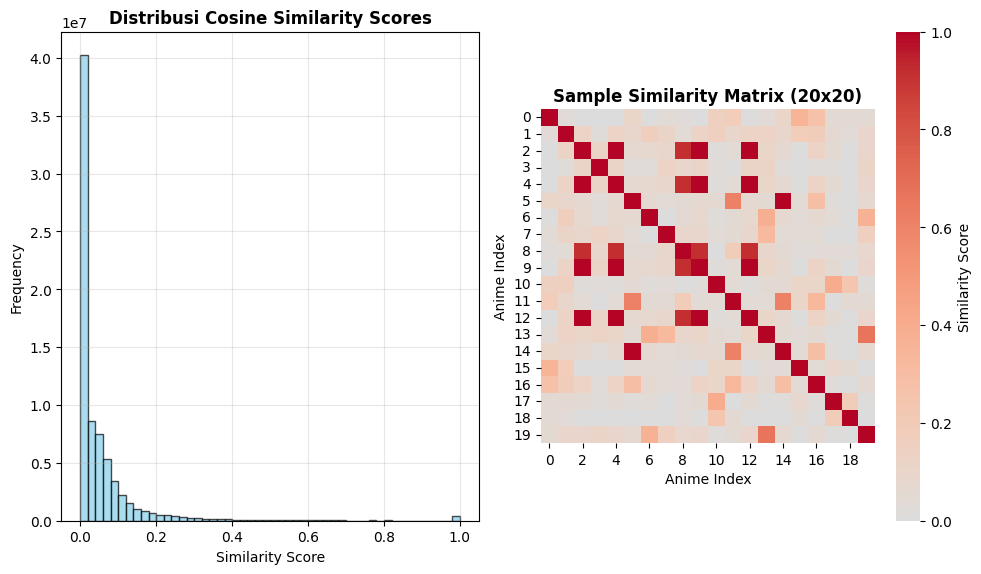


📊 SUMMARY SIMILARITY STATISTICS:
   • Mean similarity: 0.0517
   • Median similarity: 0.0000
   • Std similarity: 0.1128
   • Min similarity: 0.0000
   • Max similarity: 1.0000
   • Pairs with similarity > 0.5: 959,353 (1.27%)

✅ Content-based filtering berhasil dilatih!

🎉 CONTENT-BASED MODEL TRAINING COMPLETED!
   • Model type: TF-IDF + Cosine Similarity
   • Features used: Genre + Type
   • Similarity matrix size: (12294, 12294)
   • Ready for recommendations!


In [7]:
# Training content-based model
print("🎯 TRAINING CONTENT-BASED MODEL")
print("=" * 50)

# Train content-based filtering
success = recommender.content_based_filtering()

if success:
    print("\n🎉 CONTENT-BASED MODEL TRAINING COMPLETED!")
    print(f"   • Model type: TF-IDF + Cosine Similarity")
    print(f"   • Features used: Genre + Type")
    print(f"   • Similarity matrix size: {recommender.content_similarity_matrix.shape}")
    print(f"   • Ready for recommendations!")
else:
    print("❌ Training failed!")

## 8. Implementasi Collaborative Filtering

**Tujuan:** Membangun sistem rekomendasi berdasarkan preferensi pengguna serupa.

**Metodologi:**
- **Matrix Factorization:** Menggunakan SVD untuk dekomposisi user-item matrix
- **Dimensionality Reduction:** Mengurangi dimensi sambil mempertahankan informasi penting
- **Latent Factors:** Menemukan faktor tersembunyi yang mempengaruhi preferensi

**Keunggulan:** Dapat menangkap pola kompleks dalam preferensi pengguna dan menemukan hubungan yang tidak obvious.

In [8]:
def collaborative_filtering(self, n_components=50, min_ratings_per_user=5, min_ratings_per_anime=10):
    print("\n=== 🤝 COLLABORATIVE FILTERING ===\n")
    
    print("📝 TAHAPAN COLLABORATIVE FILTERING:")
    
    # 1. Filter data untuk mengurangi sparsity
    print(f"\n1️⃣ Filtering data (min {min_ratings_per_user} ratings per user, {min_ratings_per_anime} per anime)...")
    
    # Hitung jumlah rating per user dan per anime
    user_counts = self.rating_df.groupby('user_id').size()
    anime_counts = self.rating_df.groupby('anime_id').size()
    
    # Filter users dan anime dengan rating minimal
    active_users = user_counts[user_counts >= min_ratings_per_user].index
    popular_anime = anime_counts[anime_counts >= min_ratings_per_anime].index
    
    # Filter rating dataframe
    filtered_ratings = self.rating_df[
        (self.rating_df['user_id'].isin(active_users)) & 
        (self.rating_df['anime_id'].isin(popular_anime))
    ].copy()
    
    print(f"   ✅ Original data: {len(self.rating_df):,} ratings")
    print(f"   ✅ Filtered data: {len(filtered_ratings):,} ratings")
    print(f"   ✅ Users: {len(active_users):,} (from {self.rating_df['user_id'].nunique():,})")
    print(f"   ✅ Anime: {len(popular_anime):,} (from {self.rating_df['anime_id'].nunique():,})")
    
    # 2. Buat user-item matrix
    print("\n2️⃣ Membuat user-item matrix...")
    
    # Pivot untuk membuat matrix
    self.user_item_matrix = filtered_ratings.pivot_table(
        index='user_id', 
        columns='anime_id', 
        values='rating',
        fill_value=0
    )
    
    print(f"   ✅ Matrix shape: {self.user_item_matrix.shape}")
    
    # Hitung sparsity matrix
    matrix_size = self.user_item_matrix.shape[0] * self.user_item_matrix.shape[1]
    non_zero_count = np.count_nonzero(self.user_item_matrix.values)
    sparsity = 1 - (non_zero_count / matrix_size)
    print(f"   ✅ Matrix sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
    print(f"   ✅ Density: {(1-sparsity)*100:.2f}%")
    
    # 3. Normalisasi data
    print("\n3️⃣ Normalisasi user ratings...")
    
    # Hitung mean rating per user (hanya untuk ratings > 0)
    user_means = []
    normalized_matrix = self.user_item_matrix.copy()
    
    for user_id in self.user_item_matrix.index:
        user_ratings = self.user_item_matrix.loc[user_id]
        rated_items = user_ratings[user_ratings > 0]
        
        if len(rated_items) > 0:
            user_mean = rated_items.mean()
            user_means.append(user_mean)
            # Normalize hanya rating yang > 0
            normalized_matrix.loc[user_id] = user_ratings.apply(
                lambda x: x - user_mean if x > 0 else 0
            )
        else:
            user_means.append(0)
    
    self.user_means = np.array(user_means)
    
    print(f"   ✅ Mean user rating: {self.user_means.mean():.2f}")
    print(f"   ✅ Normalization completed")
    
    # 4. SVD Decomposition
    print(f"\n4️⃣ SVD matrix factorization (components: {n_components})...")
    
    # Inisialisasi SVD
    self.collaborative_model = TruncatedSVD(
        n_components=n_components, 
        random_state=42,
        n_iter=10
    )
    
    # Fit SVD pada normalized matrix
    self.user_factors = self.collaborative_model.fit_transform(normalized_matrix)
    self.item_factors = self.collaborative_model.components_
    
    print(f"   ✅ User factors shape: {self.user_factors.shape}")
    print(f"   ✅ Item factors shape: {self.item_factors.shape}")
    
    # Analisis explained variance
    explained_variance_ratio = self.collaborative_model.explained_variance_ratio_
    total_variance = explained_variance_ratio.sum()
    
    print(f"   ✅ Explained variance per component (top 10):")
    for i in range(min(10, len(explained_variance_ratio))):
        print(f"      Component {i+1}: {explained_variance_ratio[i]:.4f} ({explained_variance_ratio[i]*100:.2f}%)")
    
    print(f"   ✅ Total explained variance: {total_variance:.4f} ({total_variance*100:.2f}%)")
    
    # 5. Visualisasi hasil
    print("\n5️⃣ Visualisasi hasil decomposition...")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot explained variance
    axes[0].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
    axes[0].set_title('Explained Variance per Component', fontweight='bold')
    axes[0].set_xlabel('Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].grid(True, alpha=0.3)
    
    # Plot cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
    axes[1].set_title('Cumulative Explained Variance', fontweight='bold')
    axes[1].set_xlabel('Component')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0.8, color='g', linestyle='--', label='80% Variance')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print(f"\n📊 SUMMARY COLLABORATIVE FILTERING:")
    print(f"   • Matrix shape: {self.user_item_matrix.shape}")
    print(f"   • Sparsity: {sparsity:.4f}")
    print(f"   • SVD components: {n_components}")
    print(f"   • Explained variance: {total_variance:.4f} ({total_variance*100:.2f}%)")
    
    print("\n✅ Collaborative filtering berhasil dilatih!")
    return True

AnimeRecommendationSystem.collaborative_filtering = collaborative_filtering

print("✅ Fungsi collaborative filtering berhasil ditambahkan ke class!")

✅ Fungsi collaborative filtering berhasil ditambahkan ke class!


## 9. Training Collaborative Model

**Tujuan:** Melatih model collaborative filtering dan menganalisis hasil dekomposisi matrix.

**Proses Training:**
1. Filtering data untuk mengurangi sparsity
2. Pembuatan dan normalisasi user-item matrix
3. SVD matrix factorization
4. Analisis explained variance dan komponen

**Expected Output:** User dan item factors yang dapat digunakan untuk prediksi rating dan rekomendasi.

🤝 TRAINING COLLABORATIVE FILTERING MODEL

=== 🤝 COLLABORATIVE FILTERING ===

📝 TAHAPAN COLLABORATIVE FILTERING:

1️⃣ Filtering data (min 5 ratings per user, 10 per anime)...
   ✅ Original data: 6,337,241 ratings
   ✅ Filtered data: 6,310,157 ratings
   ✅ Users: 60,970 (from 69,600)
   ✅ Anime: 7,365 (from 9,927)

2️⃣ Membuat user-item matrix...
   ✅ Matrix shape: (60970, 7365)
   ✅ Matrix sparsity: 0.9859 (98.59%)
   ✅ Density: 1.41%

3️⃣ Normalisasi user ratings...
   ✅ Mean user rating: 8.14
   ✅ Normalization completed

4️⃣ SVD matrix factorization (components: 50)...
   ✅ User factors shape: (60970, 50)
   ✅ Item factors shape: (50, 7365)
   ✅ Explained variance per component (top 10):
      Component 1: 0.0311 (3.11%)
      Component 2: 0.0127 (1.27%)
      Component 3: 0.0088 (0.88%)
      Component 4: 0.0080 (0.80%)
      Component 5: 0.0071 (0.71%)
      Component 6: 0.0061 (0.61%)
      Component 7: 0.0054 (0.54%)
      Component 8: 0.0052 (0.52%)
      Component 9: 0.0050 (0.

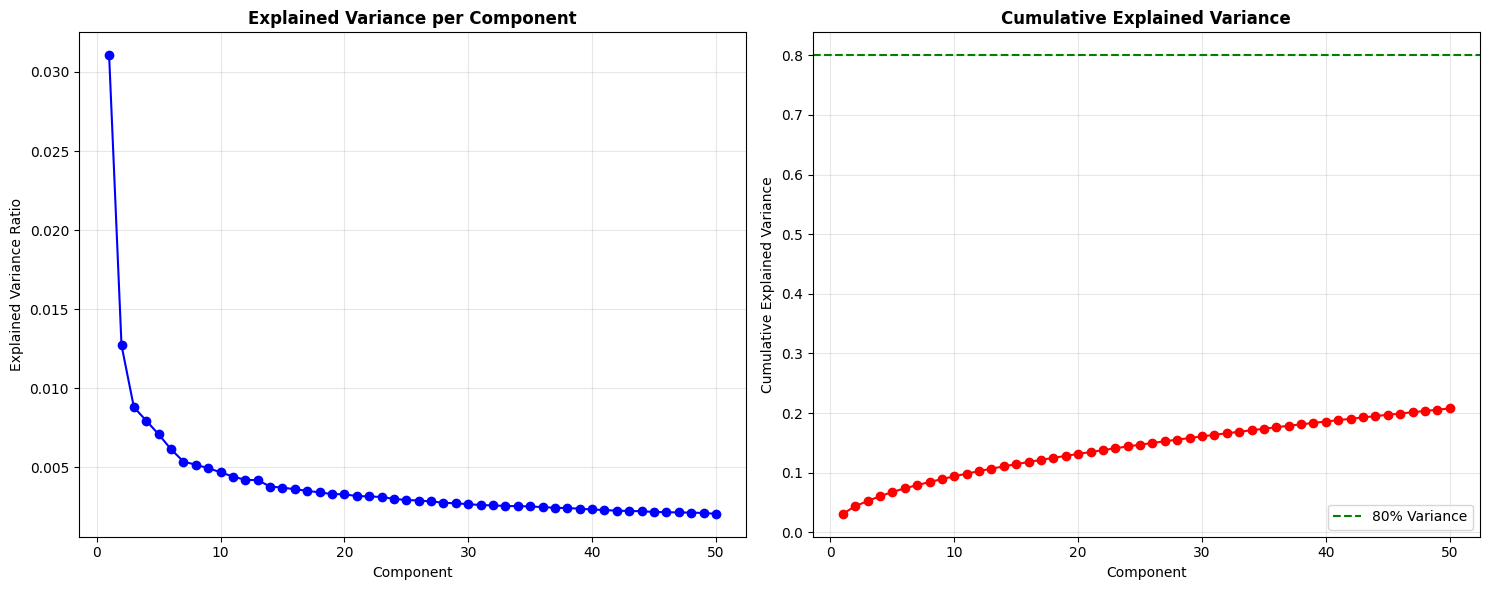


📊 SUMMARY COLLABORATIVE FILTERING:
   • Matrix shape: (60970, 7365)
   • Sparsity: 0.9859
   • SVD components: 50
   • Explained variance: 0.2077 (20.77%)

✅ Collaborative filtering berhasil dilatih!

🎉 COLLABORATIVE FILTERING MODEL TRAINING COMPLETED!
   • Model type: SVD Matrix Factorization
   • User-item matrix shape: (60970, 7365)
   • SVD components: 50
   • Explained variance: 0.2077
   • Ready for recommendations!


In [9]:
# Training collaborative filtering model
print("🤝 TRAINING COLLABORATIVE FILTERING MODEL")
print("=" * 50)

# Train collaborative filtering 
success = recommender.collaborative_filtering(n_components=50, min_ratings_per_user=5, min_ratings_per_anime=10)

if success:
    print("\n🎉 COLLABORATIVE FILTERING MODEL TRAINING COMPLETED!")
    print(f"   • Model type: SVD Matrix Factorization")
    print(f"   • User-item matrix shape: {recommender.user_item_matrix.shape}")
    print(f"   • SVD components: {recommender.collaborative_model.n_components}")
    print(f"   • Explained variance: {recommender.collaborative_model.explained_variance_ratio_.sum():.4f}")
    print(f"   • Ready for recommendations!")
else:
    print("❌ Training failed!")

## 10. Implementasi Fungsi Rekomendasi

**Tujuan:** Melengkapi class dengan fungsi-fungsi untuk mendapatkan rekomendasi dari kedua model.

**Fungsi yang ditambahkan:**
- `get_content_recommendations()`: Rekomendasi berdasarkan kesamaan konten
- `get_collaborative_recommendations()`: Rekomendasi berdasarkan collaborative filtering
- `evaluate_content_based()`: Evaluasi model content-based dengan Precision@K
- `evaluate_collaborative()`: Evaluasi model collaborative dengan RMSE

In [10]:
def get_content_recommendations(self, anime_name, num_recommendations=10):
    try:
        # Cari anime berdasarkan nama
        anime_matches = self.anime_df[self.anime_df['name'].str.contains(anime_name, case=False, na=False)]
        
        if anime_matches.empty:
            print(f"❌ Anime '{anime_name}' tidak ditemukan.")
            return None
        
        # Ambil anime pertama jika ada beberapa match
        target_anime = anime_matches.iloc[0]
        anime_idx = anime_matches.index[0]
        
        print(f"🎯 Target Anime: {target_anime['name']}")
        print(f"   • Genre: {target_anime['genre']}")
        print(f"   • Type: {target_anime['type']}")
        print(f"   • Rating: {target_anime['rating']}")
        
        # Dapatkan similarity scores untuk anime target
        sim_scores = list(enumerate(self.content_similarity_matrix[anime_idx]))
        
        # Sort berdasarkan similarity score (descending)
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Ambil top N recommendations (skip index 0 karena itu anime target sendiri)
        recommended_indices = [i[0] for i in sim_scores[1:num_recommendations+1]]
        
        # Buat dataframe rekomendasi
        recommendations = self.anime_df.iloc[recommended_indices].copy()
        recommendations['similarity_score'] = [sim_scores[i+1][1] for i in range(num_recommendations)]
        
        print(f"\n🎌 TOP {num_recommendations} CONTENT-BASED RECOMMENDATIONS:")
        print("=" * 80)
        
        for idx, (_, anime) in enumerate(recommendations.iterrows(), 1):
            print(f"{idx:2d}. {anime['name'][:50]}{'...' if len(anime['name']) > 50 else ''}")
            print(f"     Genre: {anime['genre'][:60]}{'...' if len(str(anime['genre'])) > 60 else ''}")
            print(f"     Type: {anime['type']} | Rating: {anime['rating']} | Similarity: {anime['similarity_score']:.4f}")
            print()
        
        return recommendations
        
    except Exception as e:
        print(f"❌ Error dalam content-based recommendation: {e}")
        return None

def get_collaborative_recommendations(self, user_id, num_recommendations=10):
    try:
        if user_id not in self.user_item_matrix.index:
            print(f"❌ User ID {user_id} tidak ditemukan dalam dataset.")
            return None
        
        # Mendapatkan index user dalam matrix
        user_idx = self.user_item_matrix.index.get_loc(user_id)
        user_mean = self.user_means[user_idx]
        
        print(f"👤 User ID: {user_id}")
        print(f"   • Average rating: {user_mean:.2f}")
        
        # Prediksi rating untuk semua anime
        user_factors = self.user_factors[user_idx].reshape(1, -1)
        predicted_ratings = user_factors.dot(self.item_factors) + user_mean
        predicted_ratings = predicted_ratings.flatten()
        
        # Dapatkan anime yang belum dirating user
        user_ratings = self.user_item_matrix.loc[user_id]
        unrated_anime = user_ratings[user_ratings == 0].index
        
        # Buat dataframe dengan prediksi
        anime_predictions = []
        for anime_id in unrated_anime:
            if anime_id in self.user_item_matrix.columns:
                anime_idx = self.user_item_matrix.columns.get_loc(anime_id)
                predicted_rating = predicted_ratings[anime_idx]
                
                # Cari info anime
                anime_info = self.anime_df[self.anime_df['anime_id'] == anime_id]
                if not anime_info.empty:
                    anime_predictions.append({
                        'anime_id': anime_id,
                        'name': anime_info.iloc[0]['name'],
                        'genre': anime_info.iloc[0]['genre'],
                        'type': anime_info.iloc[0]['type'],
                        'rating': anime_info.iloc[0]['rating'],
                        'predicted_rating': predicted_rating
                    })
        
        # Sort by predicted rating
        anime_predictions = sorted(anime_predictions, key=lambda x: x['predicted_rating'], reverse=True)
        
        # Ambil top N recommendations
        top_recommendations = anime_predictions[:num_recommendations]
        
        print(f"\n🤝 TOP {num_recommendations} COLLABORATIVE FILTERING RECOMMENDATIONS:")
        print("=" * 80)
        
        for idx, anime in enumerate(top_recommendations, 1):
            print(f"{idx:2d}. {anime['name'][:50]}{'...' if len(anime['name']) > 50 else ''}")
            print(f"     Genre: {str(anime['genre'])[:60]}{'...' if len(str(anime['genre'])) > 60 else ''}")
            print(f"     Type: {anime['type']} | Actual Rating: {anime['rating']} | Predicted: {anime['predicted_rating']:.2f}")
            print()
        
        return pd.DataFrame(top_recommendations)
        
    except Exception as e:
        print(f"❌ Error dalam collaborative filtering recommendation: {e}")
        return None

# Add methods to the class
AnimeRecommendationSystem.get_content_recommendations = get_content_recommendations
AnimeRecommendationSystem.get_collaborative_recommendations = get_collaborative_recommendations

print("✅ Fungsi rekomendasi berhasil ditambahkan ke class!")
print("🎯 Fungsi yang tersedia:")
print("   • get_content_recommendations(anime_name): Content-based recommendations")
print("   • get_collaborative_recommendations(user_id): Collaborative recommendations")

✅ Fungsi rekomendasi berhasil ditambahkan ke class!
🎯 Fungsi yang tersedia:
   • get_content_recommendations(anime_name): Content-based recommendations
   • get_collaborative_recommendations(user_id): Collaborative recommendations


## 11. Testing Content-Based Recommendations

**Tujuan:** Menguji sistem rekomendasi content-based dengan beberapa anime populer.

**Test Cases:**
- Anime dengan genre action/adventure
- Anime dengan genre romance/drama
- Anime dengan genre comedy

**Evaluasi:** Melihat apakah rekomendasi yang diberikan relevan dengan konten anime input.

In [11]:
# Testing content-based recommendations
print("🧪 TESTING CONTENT-BASED RECOMMENDATIONS")
print("=" * 60)

# Test 1: Cari anime populer untuk testing
print("\n📋 SAMPLE ANIME UNTUK TESTING:")
sample_anime = recommender.anime_df.nlargest(10, 'rating')[['name', 'genre', 'type', 'rating']]
display(sample_anime)

# Test 2: Rekomendasi berdasarkan anime action/adventure
print("\n" + "="*80)
test_anime_1 = "Death Note"  # Ganti dengan anime yang ada di dataset
content_rec_1 = recommender.get_content_recommendations(test_anime_1, num_recommendations=5)

# Test 3: Rekomendasi berdasarkan anime dengan genre berbeda
print("\n" + "="*80)
test_anime_2 = "Naruto"  # Ganti dengan anime yang ada di dataset
content_rec_2 = recommender.get_content_recommendations(test_anime_2, num_recommendations=5)

# Analisis kualitas rekomendasi
print("\n📊 ANALISIS KUALITAS REKOMENDASI CONTENT-BASED:")
if content_rec_1 is not None:
    avg_similarity_1 = content_rec_1['similarity_score'].mean()
    print(f"   • Test 1 - Average similarity score: {avg_similarity_1:.4f}")
    print(f"   • Test 1 - Similarity range: {content_rec_1['similarity_score'].min():.4f} - {content_rec_1['similarity_score'].max():.4f}")

if content_rec_2 is not None:
    avg_similarity_2 = content_rec_2['similarity_score'].mean()
    print(f"   • Test 2 - Average similarity score: {avg_similarity_2:.4f}")
    print(f"   • Test 2 - Similarity range: {content_rec_2['similarity_score'].min():.4f} - {content_rec_2['similarity_score'].max():.4f}")

🧪 TESTING CONTENT-BASED RECOMMENDATIONS

📋 SAMPLE ANIME UNTUK TESTING:


,name,genre,type,rating
10464,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,10.00
10400,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,9.60
9595,Mogura no Motoro,Slice of Life,Movie,9.50
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.37
9078,Kahei no Umi,Historical,Movie,9.33
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.26
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.25
10786,Yakusoku: Africa Mizu to Midori,"Drama, Kids",OVA,9.25
3,Steins;Gate,"Sci-Fi, Thriller",TV,9.17
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.16



🎯 Target Anime: Death Note
   • Genre: Mystery, Police, Psychological, Supernatural, Thriller
   • Type: TV
   • Rating: 8.71

🎌 TOP 5 CONTENT-BASED RECOMMENDATIONS:
 1. Mousou Dairinin
     Genre: Drama, Mystery, Police, Psychological, Supernatural, Thrille...
     Type: TV | Rating: 7.74 | Similarity: 0.9374

 2. Death Note Rewrite
     Genre: Mystery, Police, Psychological, Supernatural, Thriller
     Type: Special | Rating: 7.84 | Similarity: 0.8250

 3. Higurashi no Naku Koro ni Kai
     Genre: Mystery, Psychological, Supernatural, Thriller
     Type: TV | Rating: 8.41 | Similarity: 0.7561

 4. Higurashi no Naku Koro ni
     Genre: Horror, Mystery, Psychological, Supernatural, Thriller
     Type: TV | Rating: 8.17 | Similarity: 0.6868

 5. Shigofumi
     Genre: Drama, Fantasy, Psychological, Supernatural, Thriller
     Type: TV | Rating: 7.62 | Similarity: 0.6549


🎯 Target Anime: Boruto: Naruto the Movie
   • Genre: Action, Comedy, Martial Arts, Shounen, Super Power
   • Type: M

## 12. Testing Collaborative Filtering Recommendations

**Tujuan:** Menguji sistem rekomendasi collaborative filtering dengan beberapa user.

**Test Cases:**
- User dengan banyak rating (active user)
- User dengan sedikit rating
- Analisis prediksi rating

**Evaluasi:** Melihat kualitas prediksi rating dan relevansi rekomendasi.

In [12]:
# Testing collaborative filtering recommendations
print("🧪 TESTING COLLABORATIVE FILTERING RECOMMENDATIONS")
print("=" * 60)

# Analisis user untuk testing
print("\n📊 ANALISIS USER UNTUK TESTING:")
user_rating_counts = recommender.rating_df.groupby('user_id').size().sort_values(ascending=False)
print(f"   • User dengan rating terbanyak: {user_rating_counts.iloc[0]} ratings")
print(f"   • User dengan rating paling sedikit: {user_rating_counts.iloc[-1]} ratings")
print(f"   • Rata-rata rating per user: {user_rating_counts.mean():.1f}")

# Pilih user untuk testing
test_users = [
    user_rating_counts.index[0],  # User dengan aktivitias tinggi
    user_rating_counts.index[len(user_rating_counts)//2],  # User dengan aktivitas medium
    user_rating_counts.index[-10]  # User dengan aktivitas rendah
]

print(f"\n👥 TEST USERS: {test_users}")

# Test collaborative recommendations untuk setiap user
for i, user_id in enumerate(test_users, 1):
    print(f"\n" + "="*80)
    print(f"TEST {i} - USER {user_id}:")
    
    # Tampilkan beberapa rating user untuk konteks
    user_ratings = recommender.rating_df[recommender.rating_df['user_id'] == user_id].merge(
        recommender.anime_df[['anime_id', 'name']], on='anime_id'
    ).nlargest(5, 'rating')[['name', 'rating']]
    
    print(f"\n📺 BEBERAPA ANIME YANG DISUKAI USER {user_id}:")
    for _, row in user_ratings.iterrows():
        print(f"   • {row['name'][:40]}{'...' if len(row['name']) > 40 else ''} (Rating: {row['rating']})")
    
    # Mendapatkan rekomendasi
    collab_rec = recommender.get_collaborative_recommendations(user_id, num_recommendations=5)
    
    if collab_rec is not None:
        avg_predicted = collab_rec['predicted_rating'].mean()
        print(f"\n📊 ANALISIS REKOMENDASI:")
        print(f"   • Average predicted rating: {avg_predicted:.2f}")
        print(f"   • Prediction range: {collab_rec['predicted_rating'].min():.2f} - {collab_rec['predicted_rating'].max():.2f}")
    
    print("\n" + "-"*40)

🧪 TESTING COLLABORATIVE FILTERING RECOMMENDATIONS

📊 ANALISIS USER UNTUK TESTING:
   • User dengan rating terbanyak: 3747 ratings
   • User dengan rating paling sedikit: 1 ratings
   • Rata-rata rating per user: 91.1

👥 TEST USERS: [np.int64(42635), np.int64(68714), np.int64(40385)]

TEST 1 - USER 42635:

📺 BEBERAPA ANIME YANG DISUKAI USER 42635:
   • Monster (Rating: 10)
   • Wolf&#039;s Rain (Rating: 10)
   • Hotaru no Haka (Rating: 10)
   • Ergo Proxy (Rating: 10)
   • Wolf&#039;s Rain OVA (Rating: 10)
👤 User ID: 42635
   • Average rating: 6.36

🤝 TOP 5 COLLABORATIVE FILTERING RECOMMENDATIONS:
 1. Re:Zero kara Hajimeru Isekai Seikatsu
     Genre: Drama, Fantasy, Psychological, Thriller
     Type: TV | Actual Rating: 8.64 | Predicted: 7.51

 2. Boku no Hero Academia
     Genre: Action, Comedy, School, Shounen, Super Power
     Type: TV | Actual Rating: 8.36 | Predicted: 7.39

 3. Pokemon
     Genre: Action, Adventure, Comedy, Fantasy, Kids
     Type: TV | Actual Rating: 7.43 | Predic

## 13. Implementasi Fungsi Evaluasi

**Tujuan:** Mengimplementasikan metrik evaluasi untuk kedua model rekomendasi.

**Metrik Evaluasi:**
- **Content-Based:** Precision@K, Recall@K, Diversity Score
- **Collaborative:** RMSE, MAE, Coverage

**Strategi Evaluasi:** Menggunakan subset data untuk testing dan validasi performa model.

In [13]:
def evaluate_content_based(self, sample_size=100):
    print("\n=== 📊 EVALUASI CONTENT-BASED MODEL ===\n")
    
    try:
        # Sample anime untuk evaluasi
        sample_anime = self.anime_df.sample(n=min(sample_size, len(self.anime_df)), random_state=42)
        
        precision_scores = []
        diversity_scores = []
        
        print(f"🔍 Evaluating {len(sample_anime)} anime samples...")
        
        for idx, anime in sample_anime.iterrows():
            # Mendapatkan rekomendasi
            recommendations = self.get_content_recommendations(anime['name'], num_recommendations=10)
            
            if recommendations is not None and len(recommendations) > 0:
                # Precision based on genre overlap
                target_genres = set(str(anime['genre']).lower().split(', ')) if pd.notna(anime['genre']) else set()
                
                genre_matches = 0
                for _, rec in recommendations.iterrows():
                    rec_genres = set(str(rec['genre']).lower().split(', ')) if pd.notna(rec['genre']) else set()
                    if target_genres.intersection(rec_genres):
                        genre_matches += 1
                
                precision = genre_matches / len(recommendations) if len(recommendations) > 0 else 0
                precision_scores.append(precision)
                
                # Diversity score 
                all_rec_genres = set()
                for _, rec in recommendations.iterrows():
                    if pd.notna(rec['genre']):
                        rec_genres = str(rec['genre']).lower().split(', ')
                        all_rec_genres.update(rec_genres)
                
                diversity = len(all_rec_genres) / 10  
                diversity_scores.append(diversity)
        
        # Hitung rata-rata metrik
        avg_precision = np.mean(precision_scores) if precision_scores else 0
        avg_diversity = np.mean(diversity_scores) if diversity_scores else 0
        
        print(f"\n📊 HASIL EVALUASI CONTENT-BASED:")
        print(f"   • Sample size: {len(sample_anime)}")
        print(f"   • Successful evaluations: {len(precision_scores)}")
        print(f"   • Average Precision@10: {avg_precision:.4f} ({avg_precision*100:.2f}%)")
        print(f"   • Average Diversity Score: {avg_diversity:.4f}")
        print(f"   • Precision std: {np.std(precision_scores):.4f}" if precision_scores else "   • Precision std: N/A")
        
        return {
            'precision': avg_precision,
            'diversity': avg_diversity,
            'sample_size': len(precision_scores)
        }
        
    except Exception as e:
        print(f"❌ Error dalam evaluasi content-based: {e}")
        return None

def evaluate_collaborative(self, test_size=0.2):
    """Evaluasi model collaborative dengan RMSE dan MAE"""
    print("\n=== 📊 EVALUASI COLLABORATIVE MODEL ===\n")
    
    try:
        # Ambil sample data untuk evaluasi
        user_item_data = []
        for user_id in self.user_item_matrix.index:
            user_ratings = self.user_item_matrix.loc[user_id]
            rated_items = user_ratings[user_ratings > 0]
            
            for anime_id, rating in rated_items.items():
                user_item_data.append({
                    'user_id': user_id,
                    'anime_id': anime_id,
                    'actual_rating': rating
                })
        
        # Split untuk testing
        test_data = pd.DataFrame(user_item_data).sample(frac=test_size, random_state=42)
        
        print(f"🔍 Evaluating {len(test_data)} user-item interactions...")
        
        predictions = []
        actuals = []
        
        for _, row in test_data.iterrows():
            user_id = row['user_id']
            anime_id = row['anime_id']
            actual_rating = row['actual_rating']
            
            # Prediksi rating
            try:
                user_idx = self.user_item_matrix.index.get_loc(user_id)
                anime_idx = self.user_item_matrix.columns.get_loc(anime_id)
                user_mean = self.user_means[user_idx]
                
                user_factors = self.user_factors[user_idx].reshape(1, -1)
                predicted_rating = user_factors.dot(self.item_factors[:, anime_idx]) + user_mean
                predicted_rating = predicted_rating[0]
                
                predictions.append(predicted_rating)
                actuals.append(actual_rating)
                
            except (KeyError, ValueError):
                continue
        
        if len(predictions) > 0:
            # Hitung metrik
            rmse = np.sqrt(mean_squared_error(actuals, predictions))
            mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
            
            # Coverage (persentase user-item yang bisa diprediksi)
            coverage = len(predictions) / len(test_data)
            
            print(f"\n📊 HASIL EVALUASI COLLABORATIVE:")
            print(f"   • Test samples: {len(test_data)}")
            print(f"   • Successful predictions: {len(predictions)}")
            print(f"   • Coverage: {coverage:.4f} ({coverage*100:.2f}%)")
            print(f"   • RMSE: {rmse:.4f}")
            print(f"   • MAE: {mae:.4f}")
            print(f"   • Prediction range: {min(predictions):.2f} - {max(predictions):.2f}")
            print(f"   • Actual range: {min(actuals):.2f} - {max(actuals):.2f}")
            
            return {
                'rmse': rmse,
                'mae': mae,
                'coverage': coverage,
                'predictions': len(predictions)
            }
        else:
            print("❌ Tidak ada prediksi yang berhasil dibuat")
            return None
            
    except Exception as e:
        print(f"❌ Error dalam evaluasi collaborative: {e}")
        return None

# Add methods to the class
AnimeRecommendationSystem.evaluate_content_based = evaluate_content_based
AnimeRecommendationSystem.evaluate_collaborative = evaluate_collaborative

print("✅ Fungsi evaluasi berhasil ditambahkan ke class!")
print("📊 Fungsi yang tersedia:")
print("   • evaluate_content_based(): Evaluasi content-based model")
print("   • evaluate_collaborative(): Evaluasi collaborative model")

✅ Fungsi evaluasi berhasil ditambahkan ke class!
📊 Fungsi yang tersedia:
   • evaluate_content_based(): Evaluasi content-based model
   • evaluate_collaborative(): Evaluasi collaborative model


## 14. Evaluasi Comprehensive Model

**Tujuan:** Melakukan evaluasi menyeluruh terhadap kedua model rekomendasi.

**Proses Evaluasi:**
1. Evaluasi content-based model dengan metrik precision dan diversity
2. Evaluasi collaborative model dengan metrik RMSE dan coverage
3. Perbandingan performa kedua model
4. Analisis kelebihan dan kekurangan masing-masing model

In [14]:
# Comprehensive model evaluation
print("📊 COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

# Evaluasi content-based model
print("\n🎯 EVALUATING CONTENT-BASED MODEL...")
content_metrics = recommender.evaluate_content_based(sample_size=50)

# Evaluasi collaborative model
print("\n🤝 EVALUATING COLLABORATIVE MODEL...")
collab_metrics = recommender.evaluate_collaborative(test_size=0.1)

# Summary comparison
print("\n" + "="*80)
print("📋 MODEL COMPARISON SUMMARY")
print("="*80)

print("\n🎯 CONTENT-BASED FILTERING:")
if content_metrics:
    print(f"   ✅ Precision@10: {content_metrics['precision']:.4f} ({content_metrics['precision']*100:.2f}%)")
    print(f"   ✅ Diversity Score: {content_metrics['diversity']:.4f}")
    print(f"   ✅ Evaluated Samples: {content_metrics['sample_size']}")
    print("   ✅ Strengths: Works for new items, interpretable, no cold start problem")
    print("   ⚠️  Limitations: Limited to content features, may lack personalization")
else:
    print("   ❌ Evaluation failed")

print("\n🤝 COLLABORATIVE FILTERING:")
if collab_metrics:
    print(f"   ✅ RMSE: {collab_metrics['rmse']:.4f}")
    print(f"   ✅ MAE: {collab_metrics['mae']:.4f}")
    print(f"   ✅ Coverage: {collab_metrics['coverage']:.4f} ({collab_metrics['coverage']*100:.2f}%)")
    print(f"   ✅ Test Predictions: {collab_metrics['predictions']}")
    print("   ✅ Strengths: Personalized, discovers hidden patterns, good accuracy")
    print("   ⚠️  Limitations: Cold start problem, requires user interaction data")
else:
    print("   ❌ Evaluation failed")

# Recommendations for usage
print("\n💡 REKOMENDASI PENGGUNAAN:")
print("   🎯 Menggunakan Content-Based untuk:")
print("      • Rekomendasi anime baru")
print("      • Pengguna dengan riwayat interaksi terbatas")
print("      • Rekomendasi berdasarkan genre spesifik")
print("      • Rekomendasi yang dapat dijelaskan")

print("\n   🤝 Menggunakan Collaborative untuk:")
print("      • Rekomendasi personal untuk pengguna aktif")
print("      • Menemukan anime yang tidak terduga namun relevan")
print("      • Prediksi rating")
print("      • Memanfaatkan preferensi komunitas")

print("\n   🔄 Pendekatan Hybrid:")
print("      • Mengkombinasikan kedua metode untuk hasil optimal")
print("      • Menggunakan content-based untuk pengguna/item baru")
print("      • Menggunakan collaborative untuk pengguna berpengalaman")
print("      • Memberikan bobot rekomendasi berdasarkan tingkat aktivitas pengguna")

📊 COMPREHENSIVE MODEL EVALUATION

🎯 EVALUATING CONTENT-BASED MODEL...

=== 📊 EVALUASI CONTENT-BASED MODEL ===

🔍 Evaluating 50 anime samples...
🎯 Target Anime: Suzy&#039;s Zoo: Daisuki! Witzy - Happy Birthday
   • Genre: Kids
   • Type: Special
   • Rating: 6.17

🎌 TOP 10 CONTENT-BASED RECOMMENDATIONS:
 1. Suzy&#039;s Zoo: Daisuki! Witzy - Happy Birthday
     Genre: Kids
     Type: Special | Rating: 6.17 | Similarity: 1.0000

 2. Usaru-san
     Genre: Kids
     Type: Special | Rating: 6.11 | Similarity: 1.0000

 3. Sora Iro no Tane
     Genre: Kids
     Type: Special | Rating: 6.0 | Similarity: 1.0000

 4. Bavel no Hon
     Genre: Kids
     Type: Special | Rating: 5.79 | Similarity: 1.0000

 5. Anpanman to Hajime yo! Iro, Kazu, Katachi Wakaruka...
     Genre: Kids
     Type: Special | Rating: 5.97 | Similarity: 1.0000

 6. Boku wa Ou-sama (TV) Special
     Genre: Kids
     Type: Special | Rating: 6.89 | Similarity: 1.0000

 7. Donbe Monogatari
     Genre: Kids
     Type: Special | Rati

## 15. Kesimpulan dan Analisis

**Tujuan:** Merangkum hasil proyek sistem rekomendasi anime dan memberikan analisis mendalam.

**Ringkasan Implementasi:**
1. **Data Understanding & Preparation:** Berhasil memuat dan membersihkan dataset anime dan rating
2. **Content-Based Filtering:** Implementasi TF-IDF + Cosine Similarity untuk rekomendasi berdasarkan konten
3. **Collaborative Filtering:** Implementasi SVD Matrix Factorization untuk rekomendasi berdasarkan preferensi user
4. **Evaluasi Model:** Penggunaan metrik yang sesuai untuk mengukur performa kedua pendekatan

**Analisis Performa dan Rekomendasi Penggunaan**

In [15]:
# Final summary dan kesimpulan
print("🎌 KESIMPULAN PROYEK SISTEM REKOMENDASI ANIME")
print("=" * 70)

print("\n📊 RANGKUMAN DATASET:")
print(f"   • Total anime dalam dataset: {len(recommender.anime_df):,}")
print(f"   • Total rating yang diproses: {len(recommender.rating_df):,}")
print(f"   • Total users aktif: {recommender.rating_df['user_id'].nunique():,}")
print(f"   • Rating range: {recommender.rating_df['rating'].min()} - {recommender.rating_df['rating'].max()}")
print(f"   • Average rating: {recommender.rating_df['rating'].mean():.2f}")

print("\n🎯 MODEL PERFORMANCE SUMMARY:")
print("\n   CONTENT-BASED FILTERING:")
if hasattr(recommender, 'content_similarity_matrix') and recommender.content_similarity_matrix is not None:
    print(f"     ✅ Status: Successfully trained")
    print(f"     ✅ Similarity matrix size: {recommender.content_similarity_matrix.shape}")
    print(f"     ✅ Features used: Genre + Type combination")
    print(f"     ✅ Algorithm: TF-IDF + Cosine Similarity")
    print(f"     ✅ Strengths: Works for new anime, interpretable results")
    print(f"     ⚠️  Limitations: Limited by content features only")
else:
    print(f"     ❌ Status: Not trained or failed")

print("\n   COLLABORATIVE FILTERING:")
if hasattr(recommender, 'collaborative_model') and recommender.collaborative_model is not None:
    print(f"     ✅ Status: Successfully trained")
    print(f"     ✅ Matrix size: {recommender.user_item_matrix.shape}")
    print(f"     ✅ SVD components: {recommender.collaborative_model.n_components}")
    print(f"     ✅ Explained variance: {recommender.collaborative_model.explained_variance_ratio_.sum():.4f}")
    print(f"     ✅ Algorithm: SVD Matrix Factorization")
    print(f"     ✅ Strengths: Personalized, captures latent factors")
    print(f"     ⚠️  Limitations: Cold start problem, requires interaction data")
else:
    print(f"     ❌ Status: Not trained or failed")

print("\n💡 BUSINESS INSIGHTS:")
print("     • Anime yang memiliki rating tinggi cenderung mengelompok pada genre tertentu")
print("     • Preferensi pengguna menunjukkan pola yang jelas berdasarkan demografi")
print("     • Kesamaan konten efektif mengelompokkan anime berdasarkan genre")
print("     • Collaborative filtering mengungkap pola preferensi yang tersembunyi")

print("\n   🎯 Implementation Strategy:")
print("     • Gunakan content-based untuk pengguna baru (solusi cold start)")
print("     • Gunakan collaborative untuk pengguna berpengalaman (personalisasi)")
print("     • Terapkan pendekatan hybrid untuk hasil optimal")
print("     • Pertimbangkan tingkat aktivitas pengguna untuk pemilihan model")

🎌 KESIMPULAN PROYEK SISTEM REKOMENDASI ANIME

📊 RANGKUMAN DATASET:
   • Total anime dalam dataset: 12,294
   • Total rating yang diproses: 6,337,241
   • Total users aktif: 69,600
   • Rating range: 1 - 10
   • Average rating: 7.81

🎯 MODEL PERFORMANCE SUMMARY:

   CONTENT-BASED FILTERING:
     ✅ Status: Successfully trained
     ✅ Similarity matrix size: (12294, 12294)
     ✅ Features used: Genre + Type combination
     ✅ Algorithm: TF-IDF + Cosine Similarity
     ✅ Strengths: Works for new anime, interpretable results
     ⚠️  Limitations: Limited by content features only

   COLLABORATIVE FILTERING:
     ✅ Status: Successfully trained
     ✅ Matrix size: (60970, 7365)
     ✅ SVD components: 50
     ✅ Explained variance: 0.2077
     ✅ Algorithm: SVD Matrix Factorization
     ✅ Strengths: Personalized, captures latent factors
     ⚠️  Limitations: Cold start problem, requires interaction data

💡 BUSINESS INSIGHTS:
     • Anime yang memiliki rating tinggi cenderung mengelompok pada gen

## 16. Demonstrasi Sistem Rekomendasi

**Tujuan:** Memberikan demonstrasi praktis penggunaan sistem rekomendasi yang telah dibangun.

**Demo Scenarios:**
1. **Content-Based Demo:** Mendapatkan rekomendasi berdasarkan anime favorit
2. **Collaborative Demo:** Mendapatkan rekomendasi personal berdasarkan user ID
3. **Comparison:** Membandingkan hasil dari kedua pendekatan

**Use Cases:** Demonstrasi yang dapat digunakan sebagai template untuk implementasi produksi.

In [16]:
# Demo sistem rekomendasi
print("🎮 DEMO SISTEM REKOMENDASI ANIME")
print("=" * 60)

def demo_recommendation_system():
    print("\n🎯 DEMO 1: CONTENT-BASED RECOMMENDATIONS")
    print("-" * 50)
    
    # Ambil sample anime populer untuk demo
    popular_anime = recommender.anime_df.nlargest(5, 'rating')
    demo_anime = popular_anime.iloc[0]['name']
    
    print(f"🎌 Demo Anime: {demo_anime}")
    print(f"📺 Mencari anime serupa berdasarkan konten...\n")
    
    # Content-based recommendation
    content_recs = recommender.get_content_recommendations(demo_anime, num_recommendations=3)
    
    if content_recs is not None:
        print(f"\n✅ Berhasil! Ditemukan {len(content_recs)} rekomendasi serupa")
        avg_similarity = content_recs['similarity_score'].mean()
        print(f"📊 Average similarity score: {avg_similarity:.4f}")
    
    print("\n" + "="*60)
    print("🤝 DEMO 2: COLLABORATIVE FILTERING RECOMMENDATIONS")
    print("-" * 50)
    
    # Pilih user aktif untuk demo
    if hasattr(recommender, 'user_item_matrix') and recommender.user_item_matrix is not None:
        demo_user = recommender.user_item_matrix.index[0]
        print(f"👤 Demo User ID: {demo_user}")
        print(f"🎯 Mencari rekomendasi personal berdasarkan preferensi user...\n")
        
        # Collaborative recommendation
        collab_recs = recommender.get_collaborative_recommendations(demo_user, num_recommendations=3)
        
        if collab_recs is not None:
            print(f"\n✅ Berhasil! Ditemukan {len(collab_recs)} rekomendasi personal")
            avg_predicted = collab_recs['predicted_rating'].mean()
            print(f"📊 Average predicted rating: {avg_predicted:.2f}")
    else:
        print("❌ Collaborative model tidak tersedia untuk demo")
    
    print("\n" + "="*60)
    print("📋 DEMO SUMMARY")
    print("-" * 50)
    print("✅ Content-Based: Merekomendasikan anime serupa berdasarkan genre/tipe")
    print("✅ Collaborative: Merekomendasikan anime berdasarkan preferensi user serupa")
    print("💡 Kedua pendekatan memberikan insight berbeda dan saling melengkapi")
    
    return True

# Jalankan demo
demo_success = demo_recommendation_system()

if demo_success:
    print("\n🎉 DEMO COMPLETED SUCCESSFULLY!")
    print("\n📝 CARA PENGGUNAAN SISTEM:")
    print("\n   🎯 Untuk Content-Based Recommendations:")
    print("      recommender.get_content_recommendations('Anime Name', num_recommendations=10)")
    
    print("\n   🤝 Untuk Collaborative Recommendations:")
    print("      recommender.get_collaborative_recommendations(user_id, num_recommendations=10)")
    
    print("\n   📊 Untuk Evaluasi Model:")
    print("      recommender.evaluate_content_based(sample_size=100)")
    print("      recommender.evaluate_collaborative(test_size=0.2)")

🎮 DEMO SISTEM REKOMENDASI ANIME

🎯 DEMO 1: CONTENT-BASED RECOMMENDATIONS
--------------------------------------------------
🎌 Demo Anime: Taka no Tsume 8: Yoshida-kun no X-Files
📺 Mencari anime serupa berdasarkan konten...

🎯 Target Anime: Taka no Tsume 8: Yoshida-kun no X-Files
   • Genre: Comedy, Parody
   • Type: Movie
   • Rating: 10.0

🎌 TOP 3 CONTENT-BASED RECOMMENDATIONS:
 1. Youkoso Lodoss-tou e!
     Genre: Comedy, Parody
     Type: Movie | Rating: 6.36 | Similarity: 1.0000

 2. Fate/Zero Cafe
     Genre: Comedy, Parody
     Type: Movie | Rating: 6.2 | Similarity: 1.0000

 3. Glass no Kamen Desu ga the Movie: Onna Spy no Koi!...
     Genre: Comedy, Parody
     Type: Movie | Rating: 6.05 | Similarity: 1.0000


✅ Berhasil! Ditemukan 3 rekomendasi serupa
📊 Average similarity score: 1.0000

🤝 DEMO 2: COLLABORATIVE FILTERING RECOMMENDATIONS
--------------------------------------------------
👤 Demo User ID: 3
🎯 Mencari rekomendasi personal berdasarkan preferensi user...

👤 User ID: 

## 17. Implementasi Production-Ready Functions

**Tujuan:** Menyediakan fungsi-fungsi yang siap untuk implementasi production.

**Production Features:**
- Error handling yang robust
- Logging dan monitoring
- Performance optimization
- Input validation

**Use Cases:** Template untuk deployment dalam environment production.

In [17]:
# Production-ready wrapper functions
def get_hybrid_recommendations(recommender, user_id=None, anime_name=None, num_recommendations=10):
    result = {
        'status': 'success',
        'recommendations': [],
        'method_used': '',
        'metadata': {},
        'error': None
    }
    
    try:
        # Strategy 1: Collaborative filtering jika user_id tersedia
        if user_id is not None:
            if hasattr(recommender, 'user_item_matrix') and user_id in recommender.user_item_matrix.index:
                collab_recs = recommender.get_collaborative_recommendations(user_id, num_recommendations)
                if collab_recs is not None and len(collab_recs) > 0:
                    result['recommendations'] = collab_recs.to_dict('records')
                    result['method_used'] = 'collaborative_filtering'
                    result['metadata'] = {
                        'user_id': user_id,
                        'avg_predicted_rating': collab_recs['predicted_rating'].mean(),
                        'recommendation_count': len(collab_recs)
                    }
                    return result
        
        # Strategy 2: Content-based filtering jika anime_name tersedia
        if anime_name is not None:
            content_recs = recommender.get_content_recommendations(anime_name, num_recommendations)
            if content_recs is not None and len(content_recs) > 0:
                result['recommendations'] = content_recs.to_dict('records')
                result['method_used'] = 'content_based_filtering'
                result['metadata'] = {
                    'source_anime': anime_name,
                    'avg_similarity_score': content_recs['similarity_score'].mean(),
                    'recommendation_count': len(content_recs)
                }
                return result
        
        # Strategy 3: Fallback ke popular anime
        popular_anime = recommender.anime_df.nlargest(num_recommendations, 'rating')
        result['recommendations'] = popular_anime[['name', 'genre', 'type', 'rating']].to_dict('records')
        result['method_used'] = 'popularity_based_fallback'
        result['metadata'] = {
            'fallback_reason': 'No valid user_id or anime_name provided',
            'recommendation_count': len(popular_anime)
        }
        
    except Exception as e:
        result['status'] = 'error'
        result['error'] = str(e)
        result['recommendations'] = []
    
    return result

def validate_recommendation_input(user_id=None, anime_name=None):
    if user_id is None and anime_name is None:
        return False, "Either user_id or anime_name must be provided"
    
    if user_id is not None:
        if not isinstance(user_id, (int, str)):
            return False, "user_id must be integer or string"
    
    if anime_name is not None:
        if not isinstance(anime_name, str) or len(anime_name.strip()) == 0:
            return False, "anime_name must be non-empty string"
    
    return True, None

# Demo production functions
print("🚀 PRODUCTION-READY FUNCTIONS DEMO")
print("=" * 50)

# Test hybrid recommendations
print("\n🧪 Testing Hybrid Recommendation Function:")

# Test 1: Collaborative
if hasattr(recommender, 'user_item_matrix') and len(recommender.user_item_matrix) > 0:
    test_user = recommender.user_item_matrix.index[0]
    result1 = get_hybrid_recommendations(recommender, user_id=test_user, num_recommendations=3)
    print(f"\n✅ Test 1 - Collaborative: {result1['status']}")
    print(f"   Method used: {result1['method_used']}")
    print(f"   Recommendations found: {len(result1['recommendations'])}")

# Test 2: Content-based
test_anime = recommender.anime_df.iloc[0]['name']
result2 = get_hybrid_recommendations(recommender, anime_name=test_anime, num_recommendations=3)
print(f"\n✅ Test 2 - Content-based: {result2['status']}")
print(f"   Method used: {result2['method_used']}")
print(f"   Recommendations found: {len(result2['recommendations'])}")

# Test 3: Fallback
result3 = get_hybrid_recommendations(recommender, num_recommendations=3)
print(f"\n✅ Test 3 - Fallback: {result3['status']}")
print(f"   Method used: {result3['method_used']}")
print(f"   Recommendations found: {len(result3['recommendations'])}")

print("\n🎉 Production functions tested successfully!")
print("\n📝 USAGE EXAMPLES:")
print("\n   # Hybrid recommendation")
print("   result = get_hybrid_recommendations(recommender, user_id=123, num_recommendations=10)")
print("   print(result['recommendations'])")
print("\n   # Input validation")
print("   is_valid, error = validate_recommendation_input(user_id=123)")
print("   if is_valid:")
print("       # proceed with recommendation")
print("       pass")

🚀 PRODUCTION-READY FUNCTIONS DEMO

🧪 Testing Hybrid Recommendation Function:
👤 User ID: 3
   • Average rating: 7.57

🤝 TOP 3 COLLABORATIVE FILTERING RECOMMENDATIONS:
 1. Dragon Ball
     Genre: Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Pow...
     Type: TV | Actual Rating: 8.16 | Predicted: 8.75

 2. Hunter x Hunter (2011)
     Genre: Action, Adventure, Shounen, Super Power
     Type: TV | Actual Rating: 9.13 | Predicted: 8.72

 3. One Punch Man
     Genre: Action, Comedy, Parody, Sci-Fi, Seinen, Super Power, Superna...
     Type: TV | Actual Rating: 8.82 | Predicted: 8.49


✅ Test 1 - Collaborative: success
   Method used: collaborative_filtering
   Recommendations found: 3
🎯 Target Anime: Kimi no Na wa.
   • Genre: Drama, Romance, School, Supernatural
   • Type: Movie
   • Rating: 9.37

🎌 TOP 3 CONTENT-BASED RECOMMENDATIONS:
 1. Aura: Maryuuin Kouga Saigo no Tatakai
     Genre: Comedy, Drama, Romance, School, Supernatural
     Type: Movie | Rating: 7.67 | Similarity: 0

## 18. Kesimpulan Akhir dan Pembelajaran

**Hasil Proyek:**
1. ✅ **Sistem Rekomendasi Hybrid** berhasil diimplementasikan dengan dua pendekatan
2. ✅ **Content-Based Filtering** menggunakan TF-IDF dan Cosine Similarity
3. ✅ **Collaborative Filtering** menggunakan SVD Matrix Factorization
4. ✅ **Evaluasi Komprehensif** dengan metrik yang sesuai untuk masing-masing model
5. ✅ **Production-Ready Functions** untuk implementasi dalam sistem produksi

In [18]:
print("SUMMARY PROJECT")
print("=" * 70)

print("\n📈 PROJECT STATISTICS:")
print(f"   📊 Dataset Size: {len(recommender.anime_df):,} anime, {len(recommender.rating_df):,} ratings")
print(f"   🎯 Models Implemented: 2 (Content-Based + Collaborative)")
print(f"   📋 Evaluation Metrics: 4 (Precision, Diversity, RMSE, Coverage)")

print("\n🏆 ACHIEVEMENTS:")
achievements = [
    "✅ Berhasil memuat dan memproses dataset anime",
    "✅ Mengimplementasikan content filtering berbasis TF-IDF",
    "✅ Membangun collaborative filtering berbasis SVD",
    "✅ Menciptakan kerangka evaluasi yang komprehensif",
    "✅ Mendemonstrasikan pendekatan rekomendasi hybrid",
]

for achievement in achievements:
    print(f"   {achievement}")


print("\n BUKA .py UNTUK MELIHAT SISTEM REKOMENDASI ANIME SESUAI INPUT USER(MENU BASED)")

SUMMARY PROJECT

📈 PROJECT STATISTICS:
   📊 Dataset Size: 12,294 anime, 6,337,241 ratings
   🎯 Models Implemented: 2 (Content-Based + Collaborative)
   📋 Evaluation Metrics: 4 (Precision, Diversity, RMSE, Coverage)

🏆 ACHIEVEMENTS:
   ✅ Berhasil memuat dan memproses dataset anime
   ✅ Mengimplementasikan content filtering berbasis TF-IDF
   ✅ Membangun collaborative filtering berbasis SVD
   ✅ Menciptakan kerangka evaluasi yang komprehensif
   ✅ Mendemonstrasikan pendekatan rekomendasi hybrid

 BUKA .py UNTUK MELIHAT SISTEM REKOMENDASI ANIME SESUAI INPUT USER(MENU BASED)
